In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import time

# Paths and stuff
import os
import sys

sys.path.append('/home/shreyas/pySICOPOLIS/src')
from pySICOPOLIS import *

In [2]:
ds_grl40_bm5_paleo17a_CT4_BH0_m11ka_pkp_init = xr.open_dataset('/home/shreyas/update_to_develop_sicopolis/sicopolis_spinups/sico_out/grl40_bm5_paleo17a_CT4_BH0_8point5CS_spinup_0ka/grl40_bm5_paleo17a_CT4_BH0_8point5CS_spinup_0ka0006.nc')

H_data_40 = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/bm5_data_40kms.nc")
age_data_40 = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/age_data_40kms.nc")

H_data = H_data_40["H"].data
H_uncert_data = H_data_40["H_uncert"].data
zl_uncert_data = H_data_40["zl_uncert"].data

age_c_data = age_data_40["age_c"].data
age_c_uncert_data = age_data_40["age_c_uncert"].data

zs_data = H_data_40["zs"].data
mask_zs = zs_data >= -50.0
mask_zs = mask_zs.astype(float)

mask_age_c = np.zeros(age_c_data.shape)
for kc in range(age_c_data.shape[0]):
    for j in range(age_c_data.shape[1]):
        for i in range(age_c_data.shape[2]):
            if age_c_uncert_data[kc, j, i] > 0 and age_c_data[kc, j, i] >= 0 and age_c_data[kc, j, i] <= 60000 and H_data[j, i] >= 2000.0:
                mask_age_c[kc, j, i] = 1.0

In [3]:
sicopolis_dir = '/home/shreyas/update_to_develop_sicopolis/sicopolis_tuneAll_mini'
simulation = 'grl40_bm5_paleo17a_CT4_BH0_AC_BM5_ZLC_m11ka_pkp'
dict_sico_out_folder_prefixes = {"nodiff": "N",
                                 "tlm": "FORWARD",
                                 "adj": "ADJOINT",
                                 "tlm_action": "FORWARDHESSACTION",
                                 "adj_action": "ADJHESSACTION"}
dict_ad_exec_cmds_suffixes = {"nodiff": "nodiff",
                              "tlm": "forward",
                              "adj": "adjoint",
                              "tlm_action": "forwardhessaction",
                              "adj_action": "adjointhessaction"}
dict_ad_log_file_suffixes = {"nodiff": "nodiff",
                             "tlm": "tlm",
                             "adj": "adj",
                             "tlm_action": "tlm_hessaction",
                             "adj_action": "adj_hessaction"}
dict_ad_nc_suffixes = {"nodiff": "nodiff",
                       "tlm": "tlm",
                       "adj": "adj",
                       "tlm_action": "tlm_hessaction",
                       "adj_action": "adj_hessaction"}

KCMAX = 80
exp_sigma_level = dataCleaner.exp_sigma_level(zeta = np.arange(0,1+1./KCMAX,1./KCMAX),
                                              exponent = 2.0)
xModel40       = np.arange(-72.,97.,4.0)*10
yModel40       = np.arange(-345.,-56.,4.0)*10
time_ad = np.arange(3, dtype=float)
IMAX = xModel40.shape[0]-1
JMAX = yModel40.shape[0]-1
NTDAMAX = time_ad.shape[0]-1

data = ds_grl40_bm5_paleo17a_CT4_BH0_m11ka_pkp_init['q_geo'].data
log_q_geo = np.where(data > 0, np.log10(data), -5)
data = ds_grl40_bm5_paleo17a_CT4_BH0_m11ka_pkp_init['H'].data
log_H = np.where(data > 0, np.log10(data), -5)
zs = np.zeros((JMAX+1, IMAX+1), dtype=float)
zl = np.zeros((JMAX+1, IMAX+1), dtype=float)
zl0 = np.zeros((JMAX+1, IMAX+1), dtype=float)
zb = np.zeros((JMAX+1, IMAX+1), dtype=float)

log_c_dis_da = np.log10(15659.0)
log_c_slide_init = np.log10(8.5)*np.ones((JMAX+1, IMAX+1))
log_gamma_s = np.log10(0.070458)*np.ones((JMAX+1, IMAX+1))
log_s_stat = np.log10(5.0)
log_beta1 = np.log10(2.73)
log_beta2 = np.log10(7.28)
log_Pmax = np.log10(0.6)
log_mu = np.log10(9.7155)
log_RHO_A = np.log10(3300.0)
log_time_lag_asth = np.log10(3000.0)
log_flex_rig_lith = np.log10(1.e25)*np.ones((JMAX+1, IMAX+1))
log_p_weert = np.log10(3.0)
log_q_weert = np.log10(2.0)
log_enh_fact_da_dummy2d_scalar = np.log10(3.0)
log_enh_intg_da_dummy2d_scalar = np.log10(1.0)

temp_c = np.zeros((KCMAX+1, JMAX+1, IMAX+1), dtype=float)
data = ds_grl40_bm5_paleo17a_CT4_BH0_m11ka_pkp_init['age_c'].data
log_age_c = np.where(data > 0, np.log10(data), -5)

delta_tda = np.zeros((NTDAMAX+1, JMAX+1, IMAX+1), dtype=float)

dict_og_params_fields_vals = {"xx_c_slide_init": log_c_slide_init,
                              "xx_c_dis_da": log_c_dis_da,
                              "xx_q_geo": log_q_geo,
                              "xx_H": log_H,
                              "xx_gamma_s": log_gamma_s,
                              "xx_s_stat": log_s_stat,
                              "xx_beta1": log_beta1,
                              "xx_beta2": log_beta2,
                              "xx_Pmax": log_Pmax,
                              "xx_mu": log_mu,
                              "xx_RHO_A": log_RHO_A,
                              "xx_time_lag_asth": log_time_lag_asth,
                              "xx_flex_rig_lith": log_flex_rig_lith,
                              "xx_p_weert": log_p_weert,
                              "xx_q_weert": log_q_weert,
                              "xx_enh_fact_da_dummy2d_scalar": log_enh_fact_da_dummy2d_scalar,
                              "xx_enh_intg_da_dummy2d_scalar": log_enh_intg_da_dummy2d_scalar,
                              "xx_zs": zs,
                              "xx_zl": zl,
                              "xx_zl0": zl0,
                              "xx_zb": zb,
                              "xx_temp_c": temp_c,
                              "xx_age_c": log_age_c,
                              "xx_delta_tda": delta_tda}

dict_params_fields_num_dims = {"xx_c_slide_init": "2D",
                               "xx_c_dis_da": "2D",
                               "xx_q_geo": "2D",
                               "xx_H": "2D",
                               "xx_gamma_s": "2D",
                               "xx_s_stat": "2D",
                               "xx_beta1": "2D",
                               "xx_beta2": "2D",
                               "xx_Pmax": "2D",
                               "xx_mu": "2D",
                               "xx_RHO_A": "2D",
                               "xx_time_lag_asth": "2D",
                               "xx_flex_rig_lith": "2D",
                               "xx_p_weert": "2D",
                               "xx_q_weert": "2D",
                               "xx_enh_fact_da_dummy2d_scalar": "2D",
                               "xx_enh_intg_da_dummy2d_scalar": "2D",
                               "xx_zs": "2D",
                               "xx_zl": "2D",
                               "xx_zl0": "2D",
                               "xx_zb": "2D",
                               "xx_temp_c": "3D",
                               "xx_age_c": "3D",
                               "xx_delta_tda": "2DT"}

dict_params_coords = {"time_ad": time_ad,
                      "zeta_c": exp_sigma_level,
                      "y": yModel40,
                      "x": xModel40}

dict_params_attrs_type = {"xx_c_slide_init": "nodiff",
                          "xx_c_dis_da": "nodiff",
                          "xx_q_geo": "nodiff",
                          "xx_H": "nodiff",
                          "xx_gamma_s": "nodiff",
                          "xx_s_stat": "nodiff",
                          "xx_beta1": "nodiff",
                          "xx_beta2": "nodiff",
                          "xx_Pmax": "nodiff",
                          "xx_mu": "nodiff",
                          "xx_RHO_A": "nodiff",
                          "xx_time_lag_asth": "nodiff",
                          "xx_flex_rig_lith": "nodiff",
                          "xx_p_weert": "nodiff",
                          "xx_q_weert": "nodiff",
                          "xx_enh_fact_da_dummy2d_scalar": "nodiff",
                          "xx_enh_intg_da_dummy2d_scalar": "nodiff",
                          "xx_zs": "nodiff",
                          "xx_zl": "nodiff",
                          "xx_zl0": "nodiff",
                          "xx_zb": "nodiff",
                          "xx_temp_c": "nodiff",
                          "xx_age_c": "nodiff",
                          "xx_delta_tda": "nodiff"}

dict_params_fields_or_scalars = {"xx_c_slide_init": "field",
                                 "xx_c_dis_da": "scalar",
                                 "xx_q_geo": "field",
                                 "xx_H": "field",
                                 "xx_gamma_s": "field",
                                 "xx_s_stat": "scalar",
                                 "xx_beta1": "scalar",
                                 "xx_beta2": "scalar",
                                 "xx_Pmax": "scalar",
                                 "xx_mu": "scalar",
                                 "xx_RHO_A": "scalar",
                                 "xx_time_lag_asth": "scalar",
                                 "xx_flex_rig_lith": "field",
                                 "xx_p_weert": "scalar",
                                 "xx_q_weert": "scalar",
                                 "xx_enh_fact_da_dummy2d_scalar": "scalar",
                                 "xx_enh_intg_da_dummy2d_scalar": "scalar",
                                 "xx_zs": "field",
                                 "xx_zl": "field",
                                 "xx_zl0": "field",
                                 "xx_zb": "field",
                                 "xx_temp_c": "field",
                                 "xx_age_c": "field",
                                 "xx_delta_tda": "field"}

year2sec = 3.1556925445e+07
dict_masks_observables = {"H": mask_zs*H_uncert_data**(-2),
                          "zl": mask_zs*zl_uncert_data**(-2),
                          "age_c": mask_age_c*(age_c_uncert_data*year2sec)**(-2)}

dict_prior_sigmas = {"xx_c_slide_init": 0.3,
                     "xx_c_dis_da": 0.3,
                     "xx_q_geo": 0.3,
                     "xx_H": 0.3,
                     "xx_gamma_s": 0.3,
                     "xx_s_stat": 0.3,
                     "xx_beta1": 0.3,
                     "xx_beta2": 0.3,
                     "xx_Pmax": 0.3,
                     "xx_mu": 0.3,
                     "xx_RHO_A": 0.3,
                     "xx_time_lag_asth": 0.3,
                     "xx_flex_rig_lith": 0.3,
                     "xx_p_weert": 0.3,
                     "xx_q_weert": 0.3,
                     "xx_enh_fact_da_dummy2d_scalar": 0.3,
                     "xx_enh_intg_da_dummy2d_scalar": 0.3,
                     "xx_zs": 300.0,
                     "xx_zl": 300.0,
                     "xx_zl0": 300.0,
                     "xx_zb": 300.0,
                     "xx_temp_c": 0.5,
                     "xx_age_c": 0.3,
                     "xx_delta_tda": 0.1}

dict_prior_gammas = {"xx_c_slide_init": 1.0,
                     "xx_c_dis_da": 0.0,
                     "xx_q_geo": 1.0,
                     "xx_H": 1.0,
                     "xx_gamma_s": 1.0,
                     "xx_s_stat": 0.0,
                     "xx_beta1": 0.0,
                     "xx_beta2": 0.0,
                     "xx_Pmax": 0.0,
                     "xx_mu": 0.0,
                     "xx_RHO_A": 0.0,
                     "xx_time_lag_asth": 0.0,
                     "xx_flex_rig_lith": 1.0,
                     "xx_p_weert": 0.0,
                     "xx_q_weert": 0.0,
                     "xx_enh_fact_da_dummy2d_scalar": 0.0,
                     "xx_enh_intg_da_dummy2d_scalar": 0.0,
                     "xx_zs": 0.0,
                     "xx_zl": 1.0,
                     "xx_zl0": 1.0,
                     "xx_zb": 1.0,
                     "xx_temp_c": 1.0,
                     "xx_age_c": 1.0,
                     "xx_delta_tda": 1.0}

dict_prior_deltas = {"xx_c_slide_init": 0.001,
                     "xx_c_dis_da": 0.001,
                     "xx_q_geo": 0.001,
                     "xx_H": 0.001,
                     "xx_gamma_s": 0.001,
                     "xx_s_stat": 0.001,
                     "xx_beta1": 0.001,
                     "xx_beta2": 0.001,
                     "xx_Pmax": 0.001,
                     "xx_mu": 0.001,
                     "xx_RHO_A": 0.0,
                     "xx_time_lag_asth": 0.001,
                     "xx_flex_rig_lith": 0.001,
                     "xx_p_weert": 0.0,
                     "xx_q_weert": 0.0,
                     "xx_enh_fact_da_dummy2d_scalar": 0.001,
                     "xx_enh_intg_da_dummy2d_scalar": 0.001,
                     "xx_zs": 0.0,
                     "xx_zl": 0.001,
                     "xx_zl0": 0.001,
                     "xx_zb": 0.001,
                     "xx_temp_c": 0.001,
                     "xx_age_c": 0.001,
                     "xx_delta_tda": 0.001}

list_fields_to_ignore = ["xx_RHO_A", "xx_p_weert", "xx_q_weert", "xx_zs"]

# all_fields = ["xx_c_slide_init", "xx_q_geo", "xx_H", "xx_gamma_s", 
#               "xx_s_stat", "xx_beta1", "xx_beta2", "xx_Pmax", "xx_mu", "xx_c_dis_da", 
#               "xx_RHO_A", "xx_time_lag_asth", "xx_flex_rig_lith",
#               "xx_p_weert", "xx_q_weert",
#               "xx_enh_fact_da_dummy2d_scalar", "xx_enh_intg_da_dummy2d_scalar",
#               "xx_zs", "xx_zl", "xx_zl0", "xx_zb",
#               "xx_temp_c", "xx_age_c", "xx_delta_tda"]

MAX_ITERS_SOR = 1000
OMEGA_SOR = 1.5

/tmp/ipykernel_1543151/129661186.py:37: RuntimeWarning: divide by zero encountered in log10
  log_H = np.where(data > 0, np.log10(data), -5)
/tmp/ipykernel_1543151/129661186.py:61: RuntimeWarning: divide by zero encountered in log10
  log_age_c = np.where(data > 0, np.log10(data), -5)


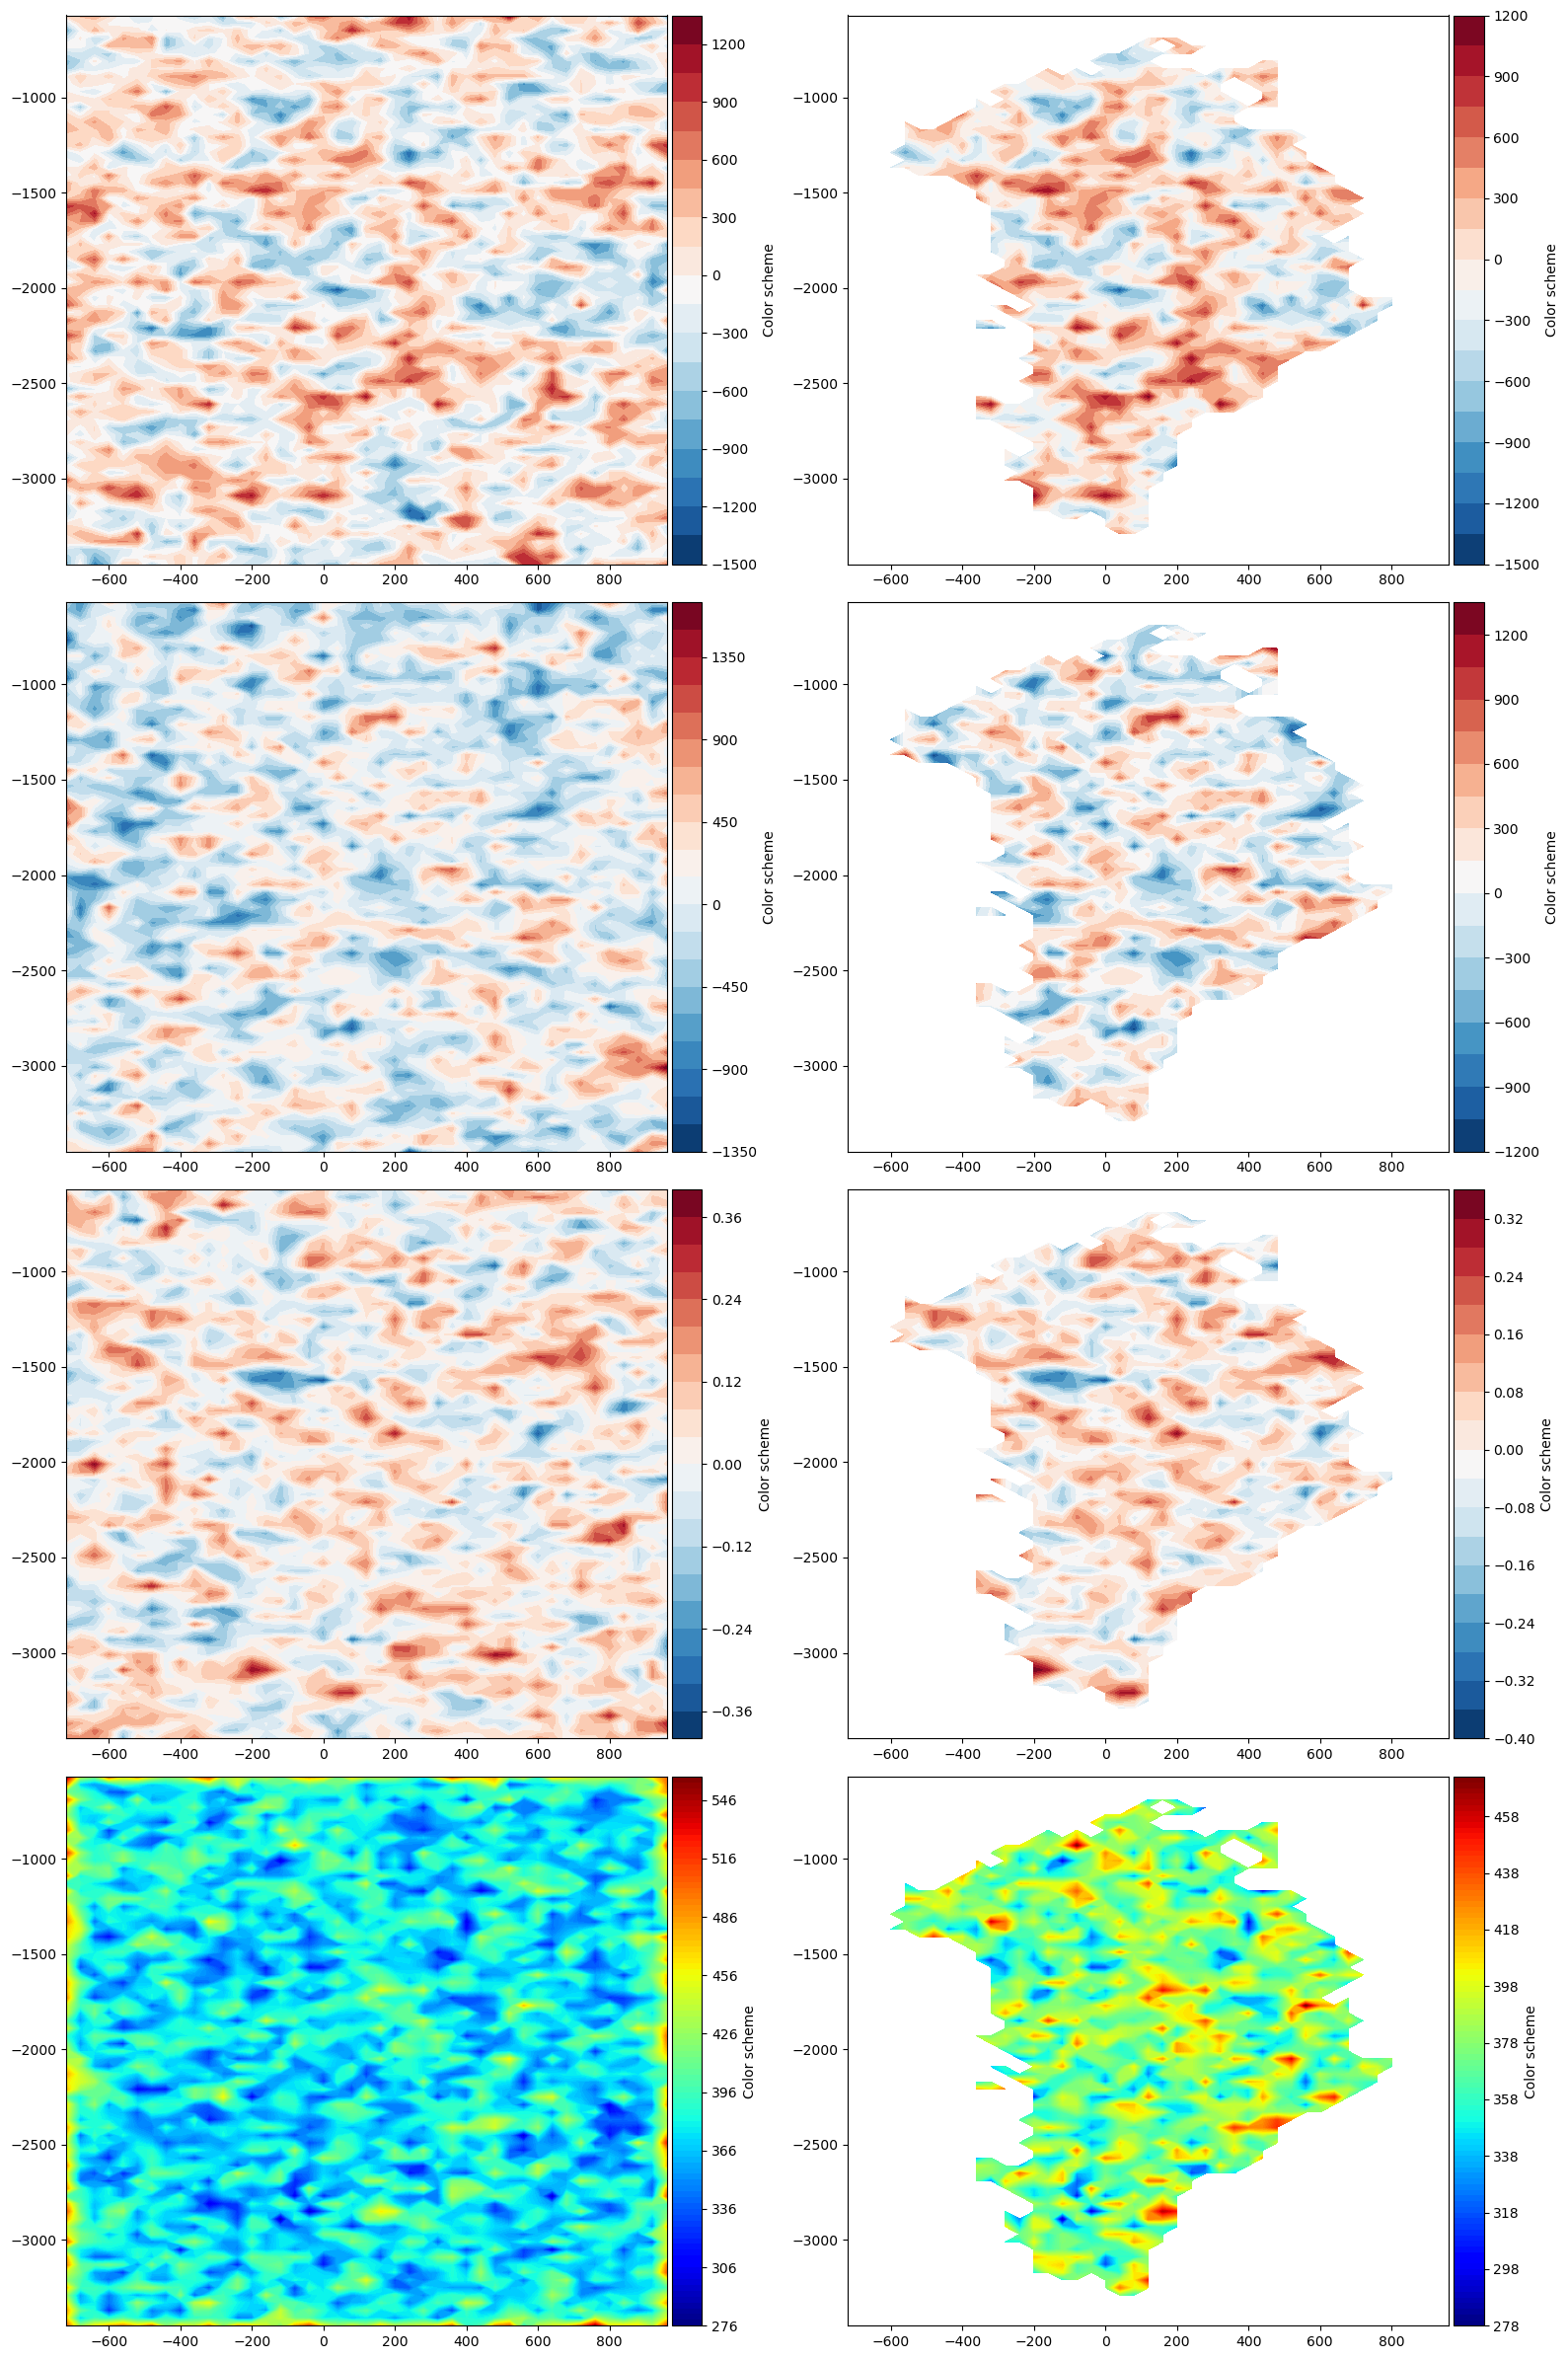

In [4]:
DA = optim.DataAssimilation(sicopolis_dir, simulation,
                            dict_sico_out_folder_prefixes, dict_ad_exec_cmds_suffixes,
                            dict_ad_log_file_suffixes, dict_ad_nc_suffixes,
                            dict_og_params_fields_vals, dict_params_fields_num_dims, 
                            dict_params_coords, dict_params_attrs_type, dict_params_fields_or_scalars, dict_masks_observables,
                            dict_prior_sigmas, dict_prior_gammas, dict_prior_deltas,
                            MAX_ITERS_SOR, OMEGA_SOR, list_fields_to_ignore, False, None, "/scratch2/shreyas/tuneAll_mini", 100, None)

ds_prior_X = DA.ds_prior_X.copy()

ds_subset_sample_prior_C_1 = DA.sample_prior_C()
ds_subset_sample_prior_C_2 = DA.sample_prior_C()
ds_mean_samples_prior_C, ds_std_samples_prior_C = DA.ds_prior_C_mean, DA.ds_prior_C_std

ds_subset_sample_prior_1 = DA.sample_prior()
ds_subset_sample_prior_2 = DA.sample_prior()
ds_mean_samples_prior, ds_std_samples_prior = DA.pointwise_marginals("prior", 100)

H_data_40 = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/bm5_data_40kms.nc")
H_data = H_data_40["H"].data
mask = 1.0*(H_data > 0)
mask[mask == 0] = np.nan

plt.rcParams["figure.figsize"] = (16,24)
fig, ax = plt.subplots(4, 2)
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_subset_sample_prior_C_1["xx_q_geod"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[0, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_subset_sample_prior_C_1["xx_q_geod"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[0, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_subset_sample_prior_C_2["xx_q_geod"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[1, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_subset_sample_prior_C_2["xx_q_geod"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[1, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_mean_samples_prior_C["xx_q_geod"].data/ds_std_samples_prior_C["xx_q_geod"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[2, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_mean_samples_prior_C["xx_q_geod"].data/ds_std_samples_prior_C["xx_q_geod"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[2, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_std_samples_prior_C["xx_q_geod"].data,
                         cmap = 'jet', nbins = 100, fig = fig, ax = ax[3, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_std_samples_prior_C["xx_q_geod"].data*mask,
                         cmap = 'jet', nbins = 100, fig = fig, ax = ax[3, 1])
plt.tight_layout()

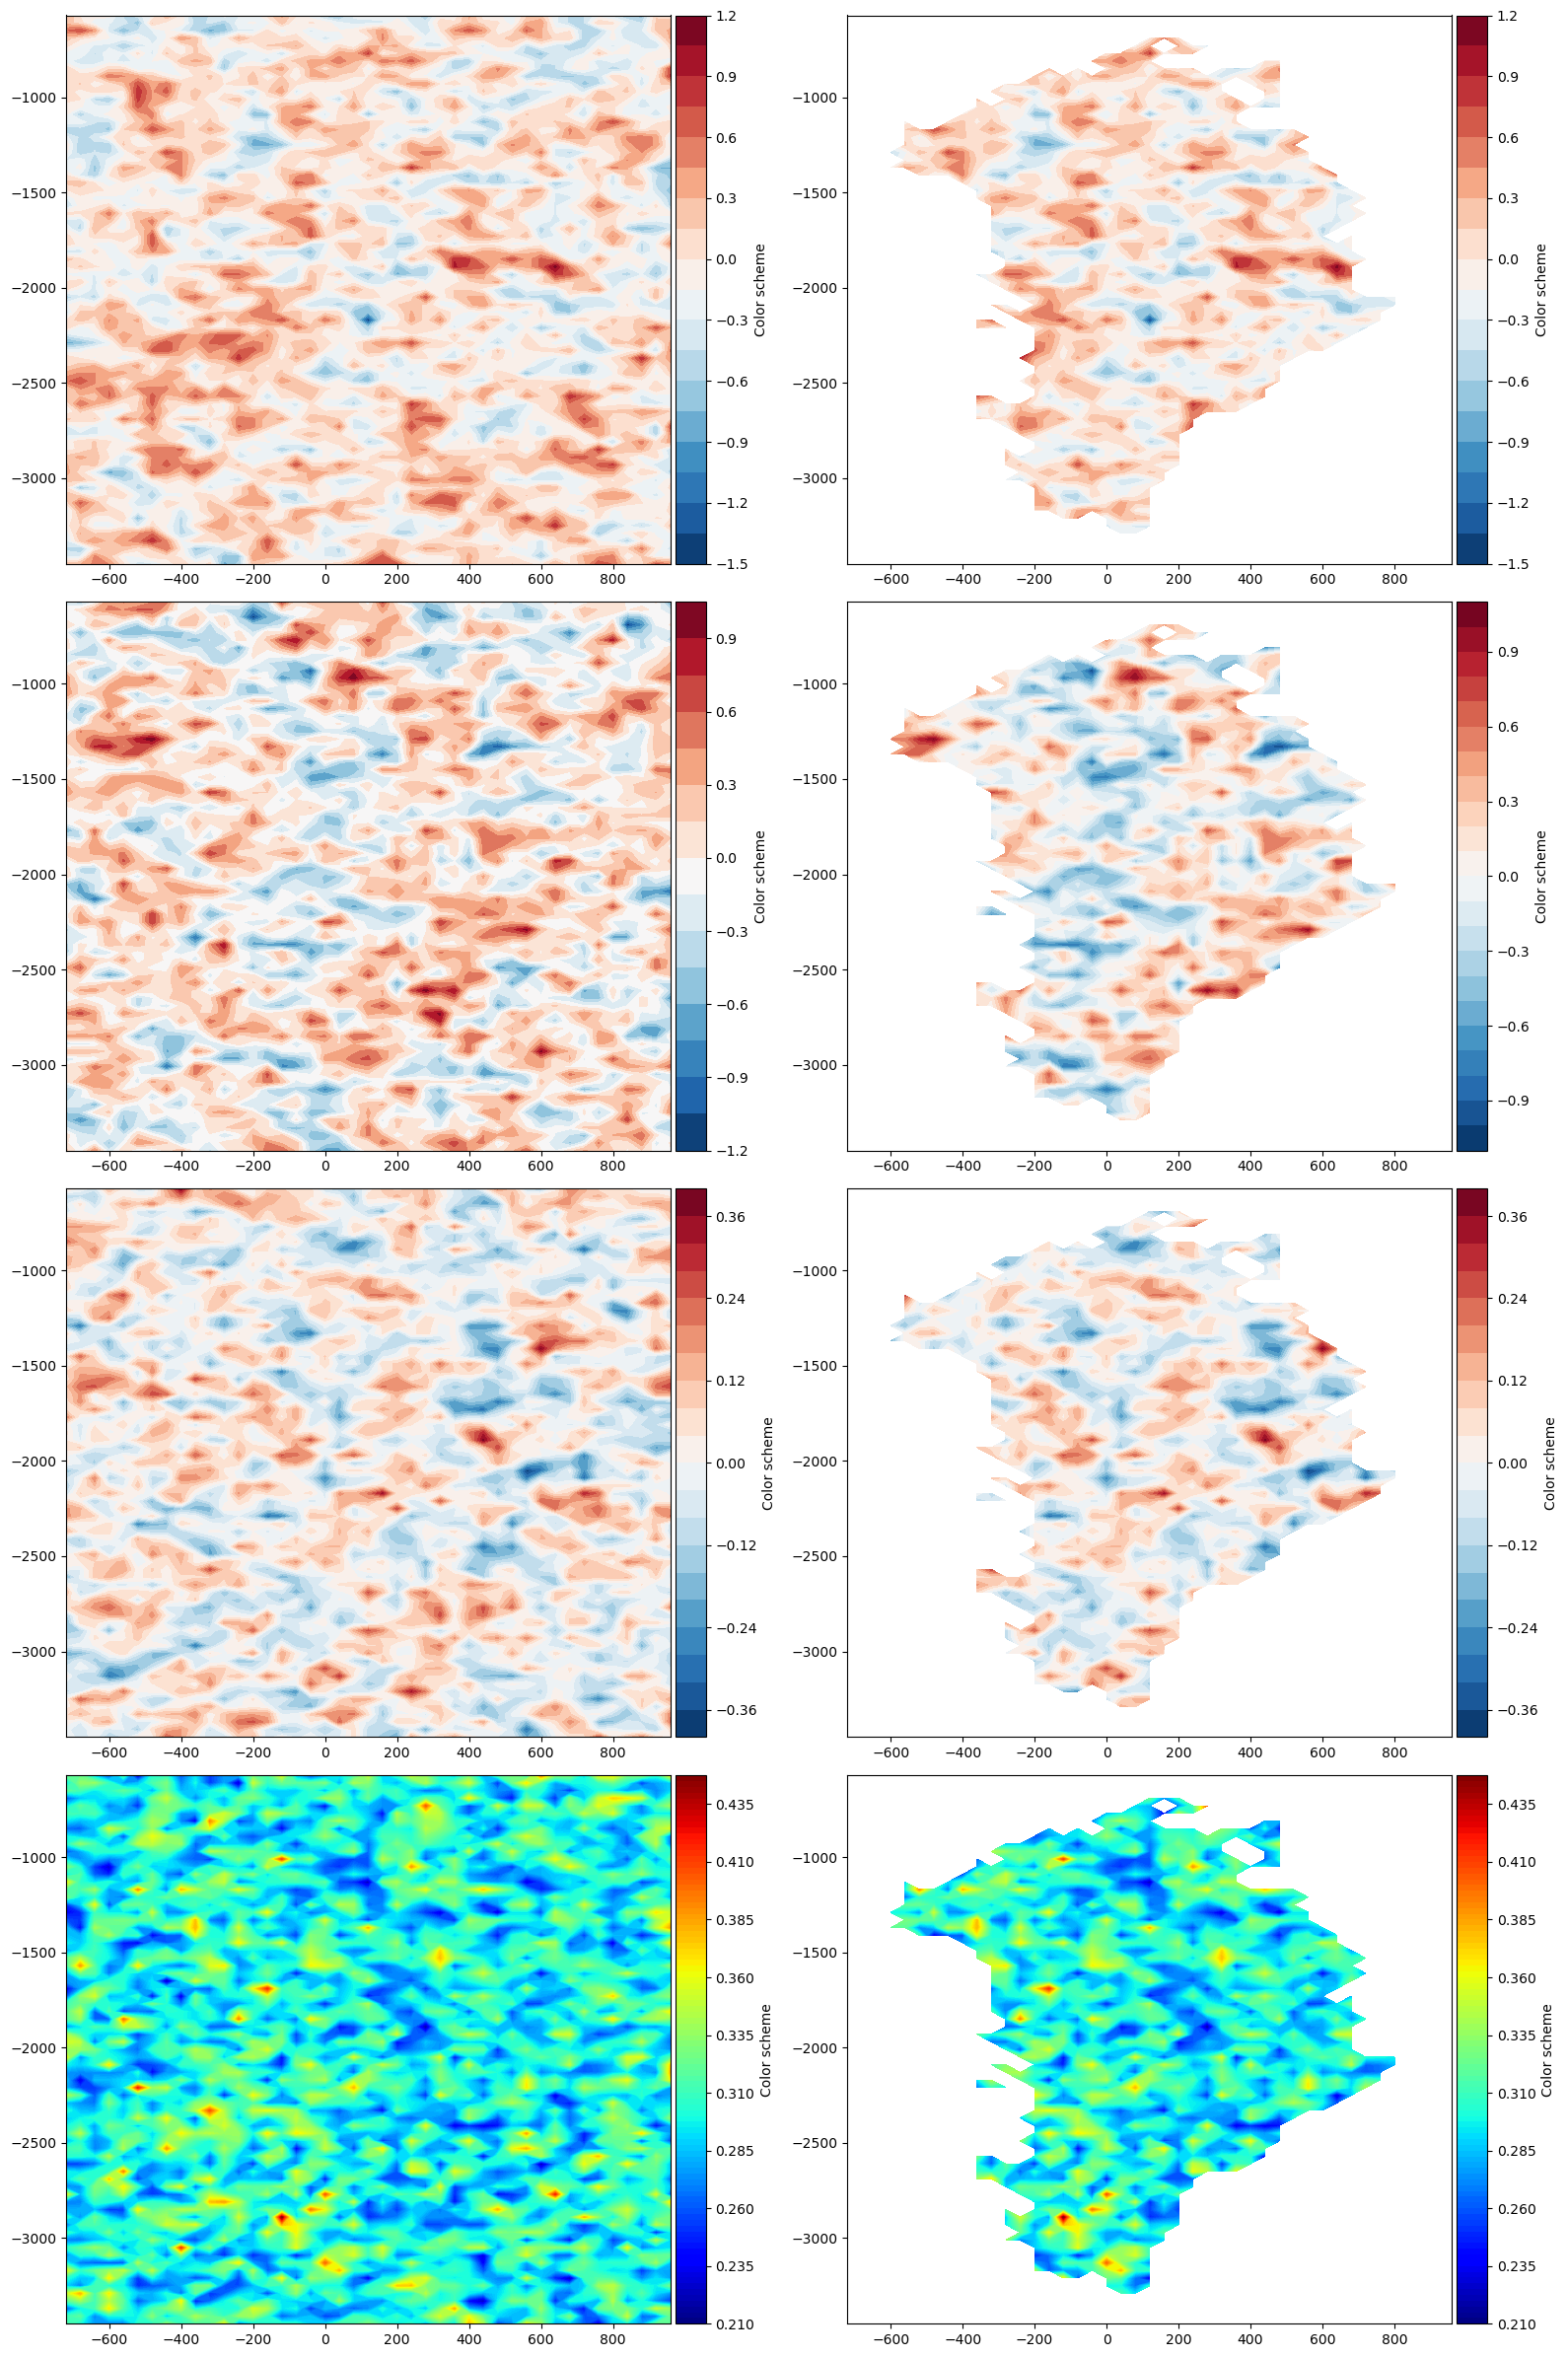

In [5]:
H_data_40 = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/bm5_data_40kms.nc")
H_data = H_data_40["H"].data
mask = 1.0*(H_data > 0)
mask[mask == 0] = np.nan

plt.rcParams["figure.figsize"] = (16,24)
fig, ax = plt.subplots(4, 2)
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_subset_sample_prior_1["xx_q_geod"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[0, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_subset_sample_prior_1["xx_q_geod"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[0, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_subset_sample_prior_2["xx_q_geod"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[1, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_subset_sample_prior_2["xx_q_geod"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[1, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_mean_samples_prior["xx_q_geod"].data/ds_std_samples_prior["xx_q_geod"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[2, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_mean_samples_prior["xx_q_geod"].data/ds_std_samples_prior["xx_q_geod"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[2, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_std_samples_prior["xx_q_geod"].data,
                         cmap = 'jet', nbins = 100, fig = fig, ax = ax[3, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_std_samples_prior["xx_q_geod"].data*mask,
                         cmap = 'jet', nbins = 100, fig = fig, ax = ax[3, 1])
plt.tight_layout()

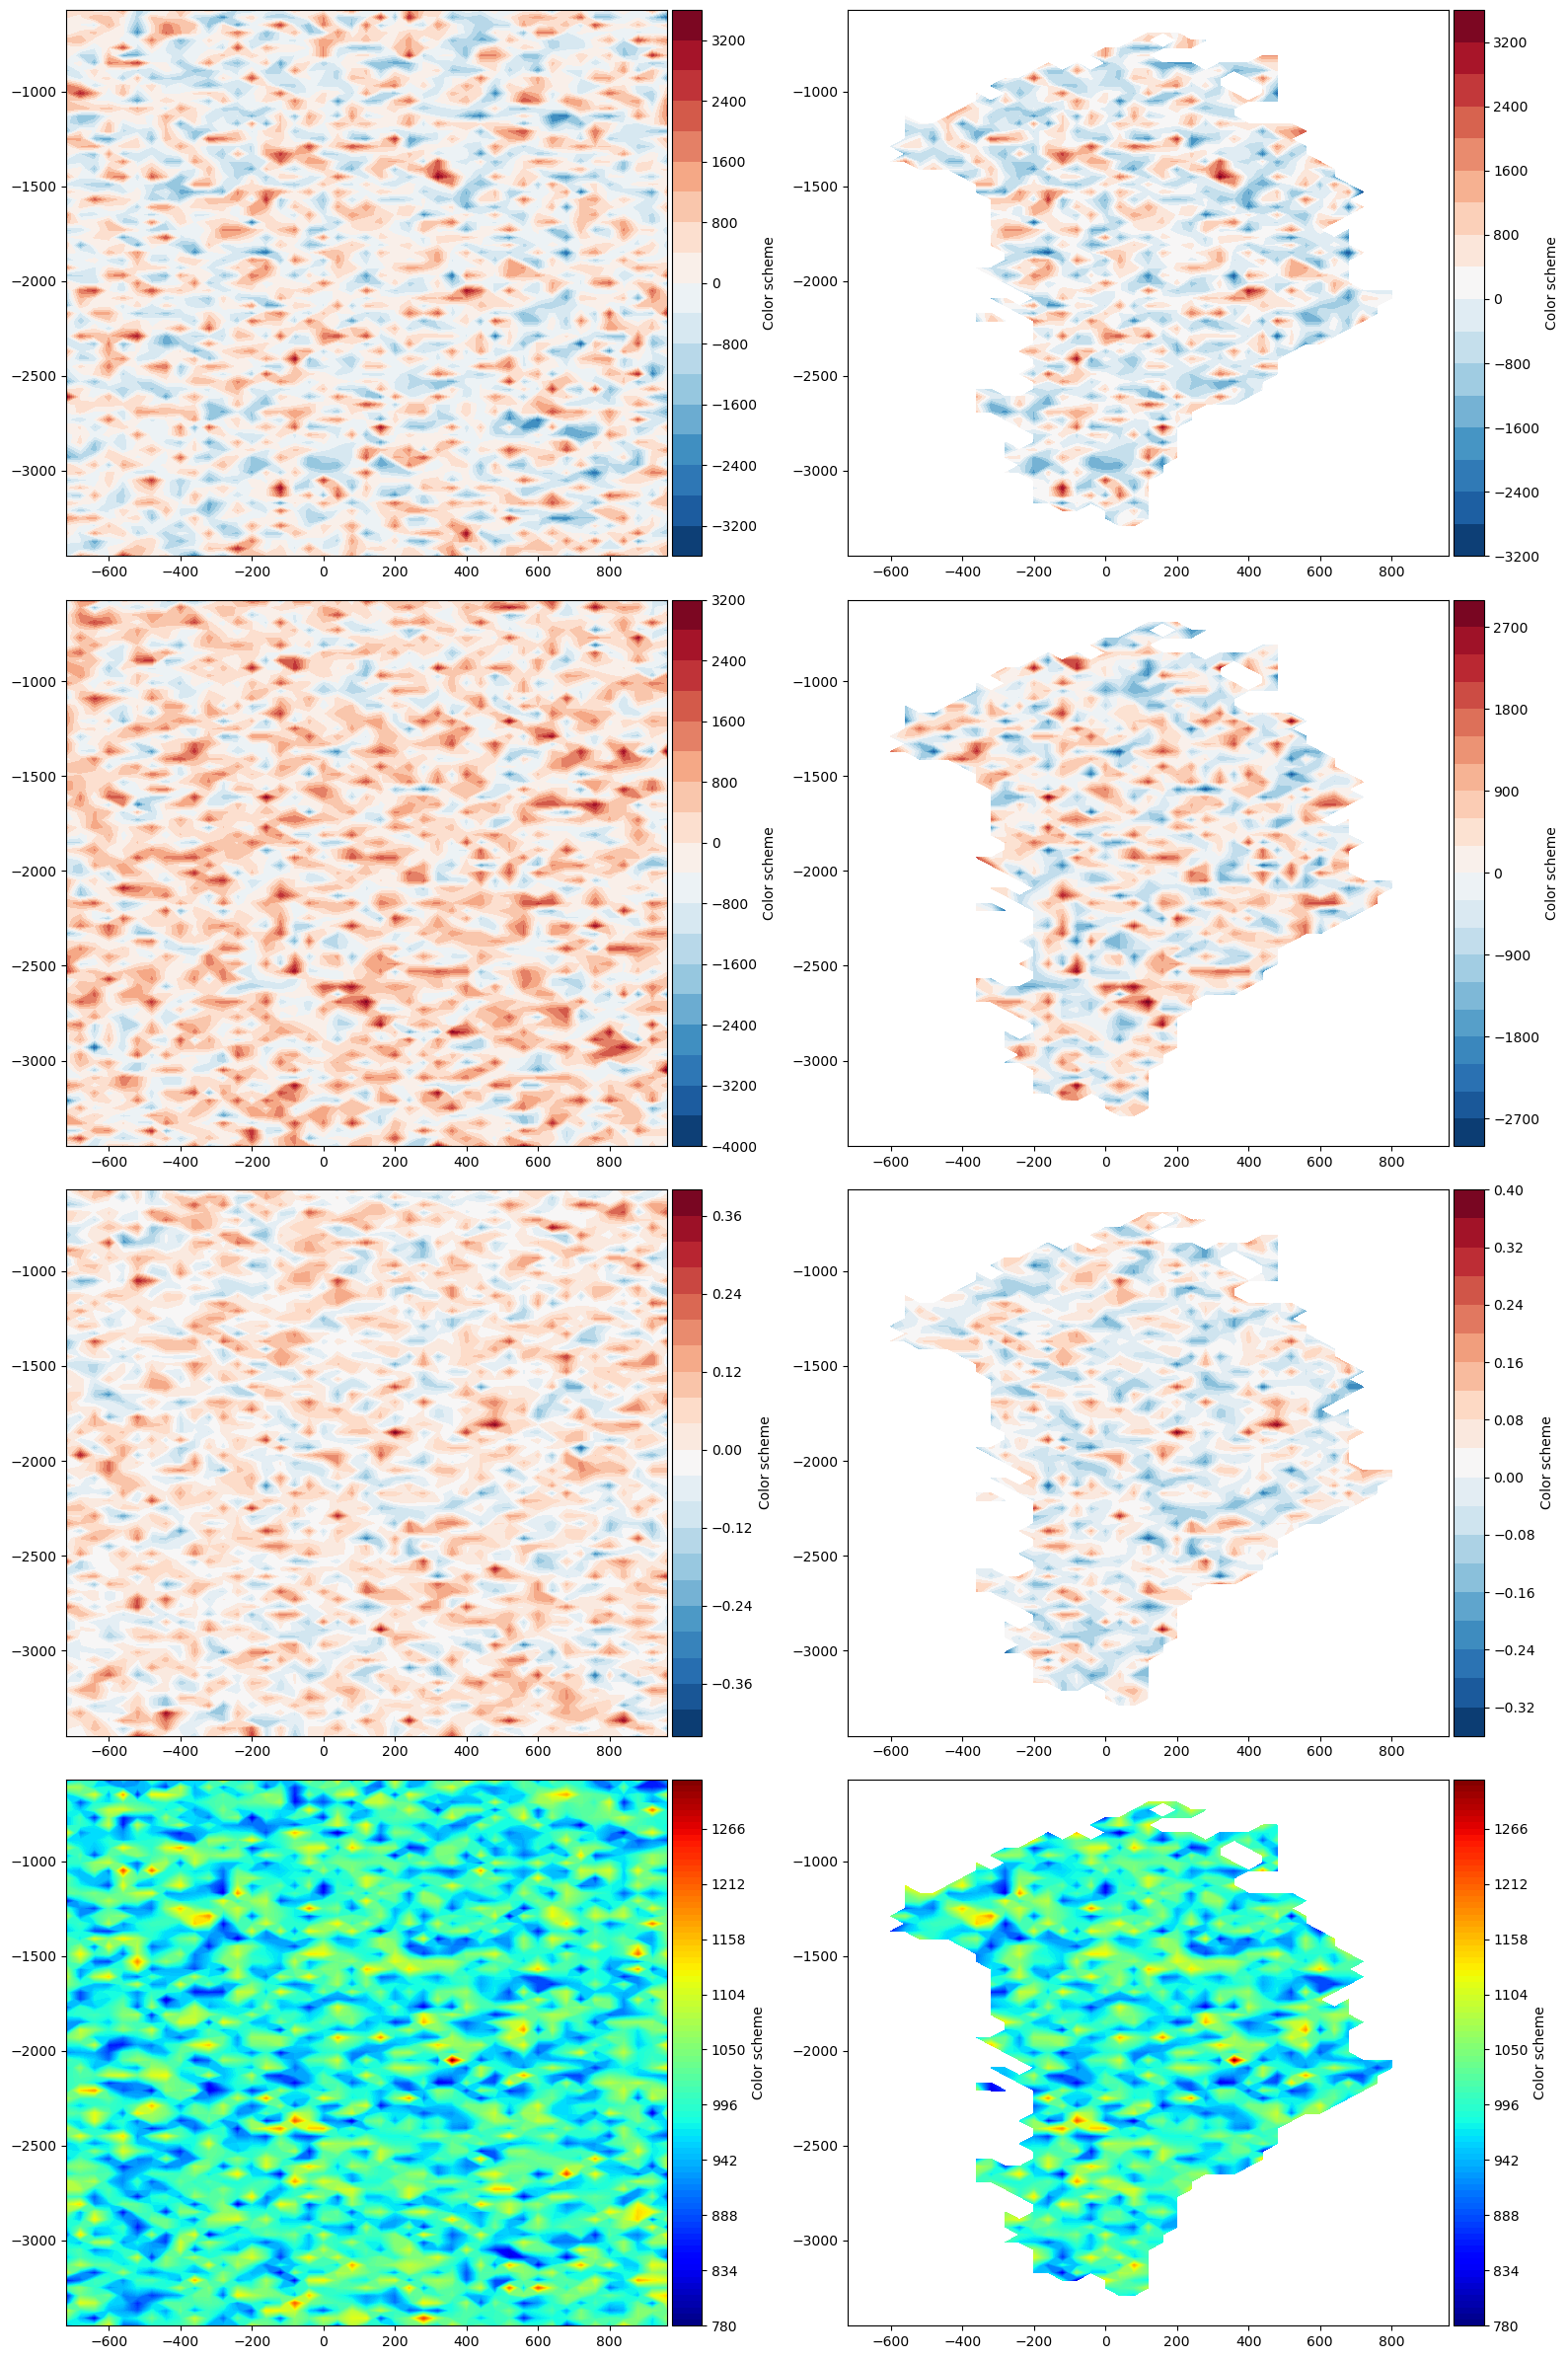

In [6]:
H_data_40 = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/bm5_data_40kms.nc")
H_data = H_data_40["H"].data
mask = 1.0*(H_data > 0)
mask[mask == 0] = np.nan

plt.rcParams["figure.figsize"] = (16,24)
fig, ax = plt.subplots(4, 2)
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_subset_sample_prior_C_1["xx_age_cd"].data[40],
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[0, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_subset_sample_prior_C_1["xx_age_cd"].data[40]*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[0, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_subset_sample_prior_C_2["xx_age_cd"].data[40],
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[1, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_subset_sample_prior_C_2["xx_age_cd"].data[40]*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[1, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_mean_samples_prior_C["xx_age_cd"].data[40]/ds_std_samples_prior_C["xx_age_cd"].data[40],
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[2, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_mean_samples_prior_C["xx_age_cd"].data[40]/ds_std_samples_prior_C["xx_age_cd"].data[40]*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[2, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_std_samples_prior_C["xx_age_cd"].data[40],
                         cmap = 'jet', nbins = 100, fig = fig, ax = ax[3, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_std_samples_prior_C["xx_age_cd"].data[40]*mask,
                         cmap = 'jet', nbins = 100, fig = fig, ax = ax[3, 1])
plt.tight_layout()

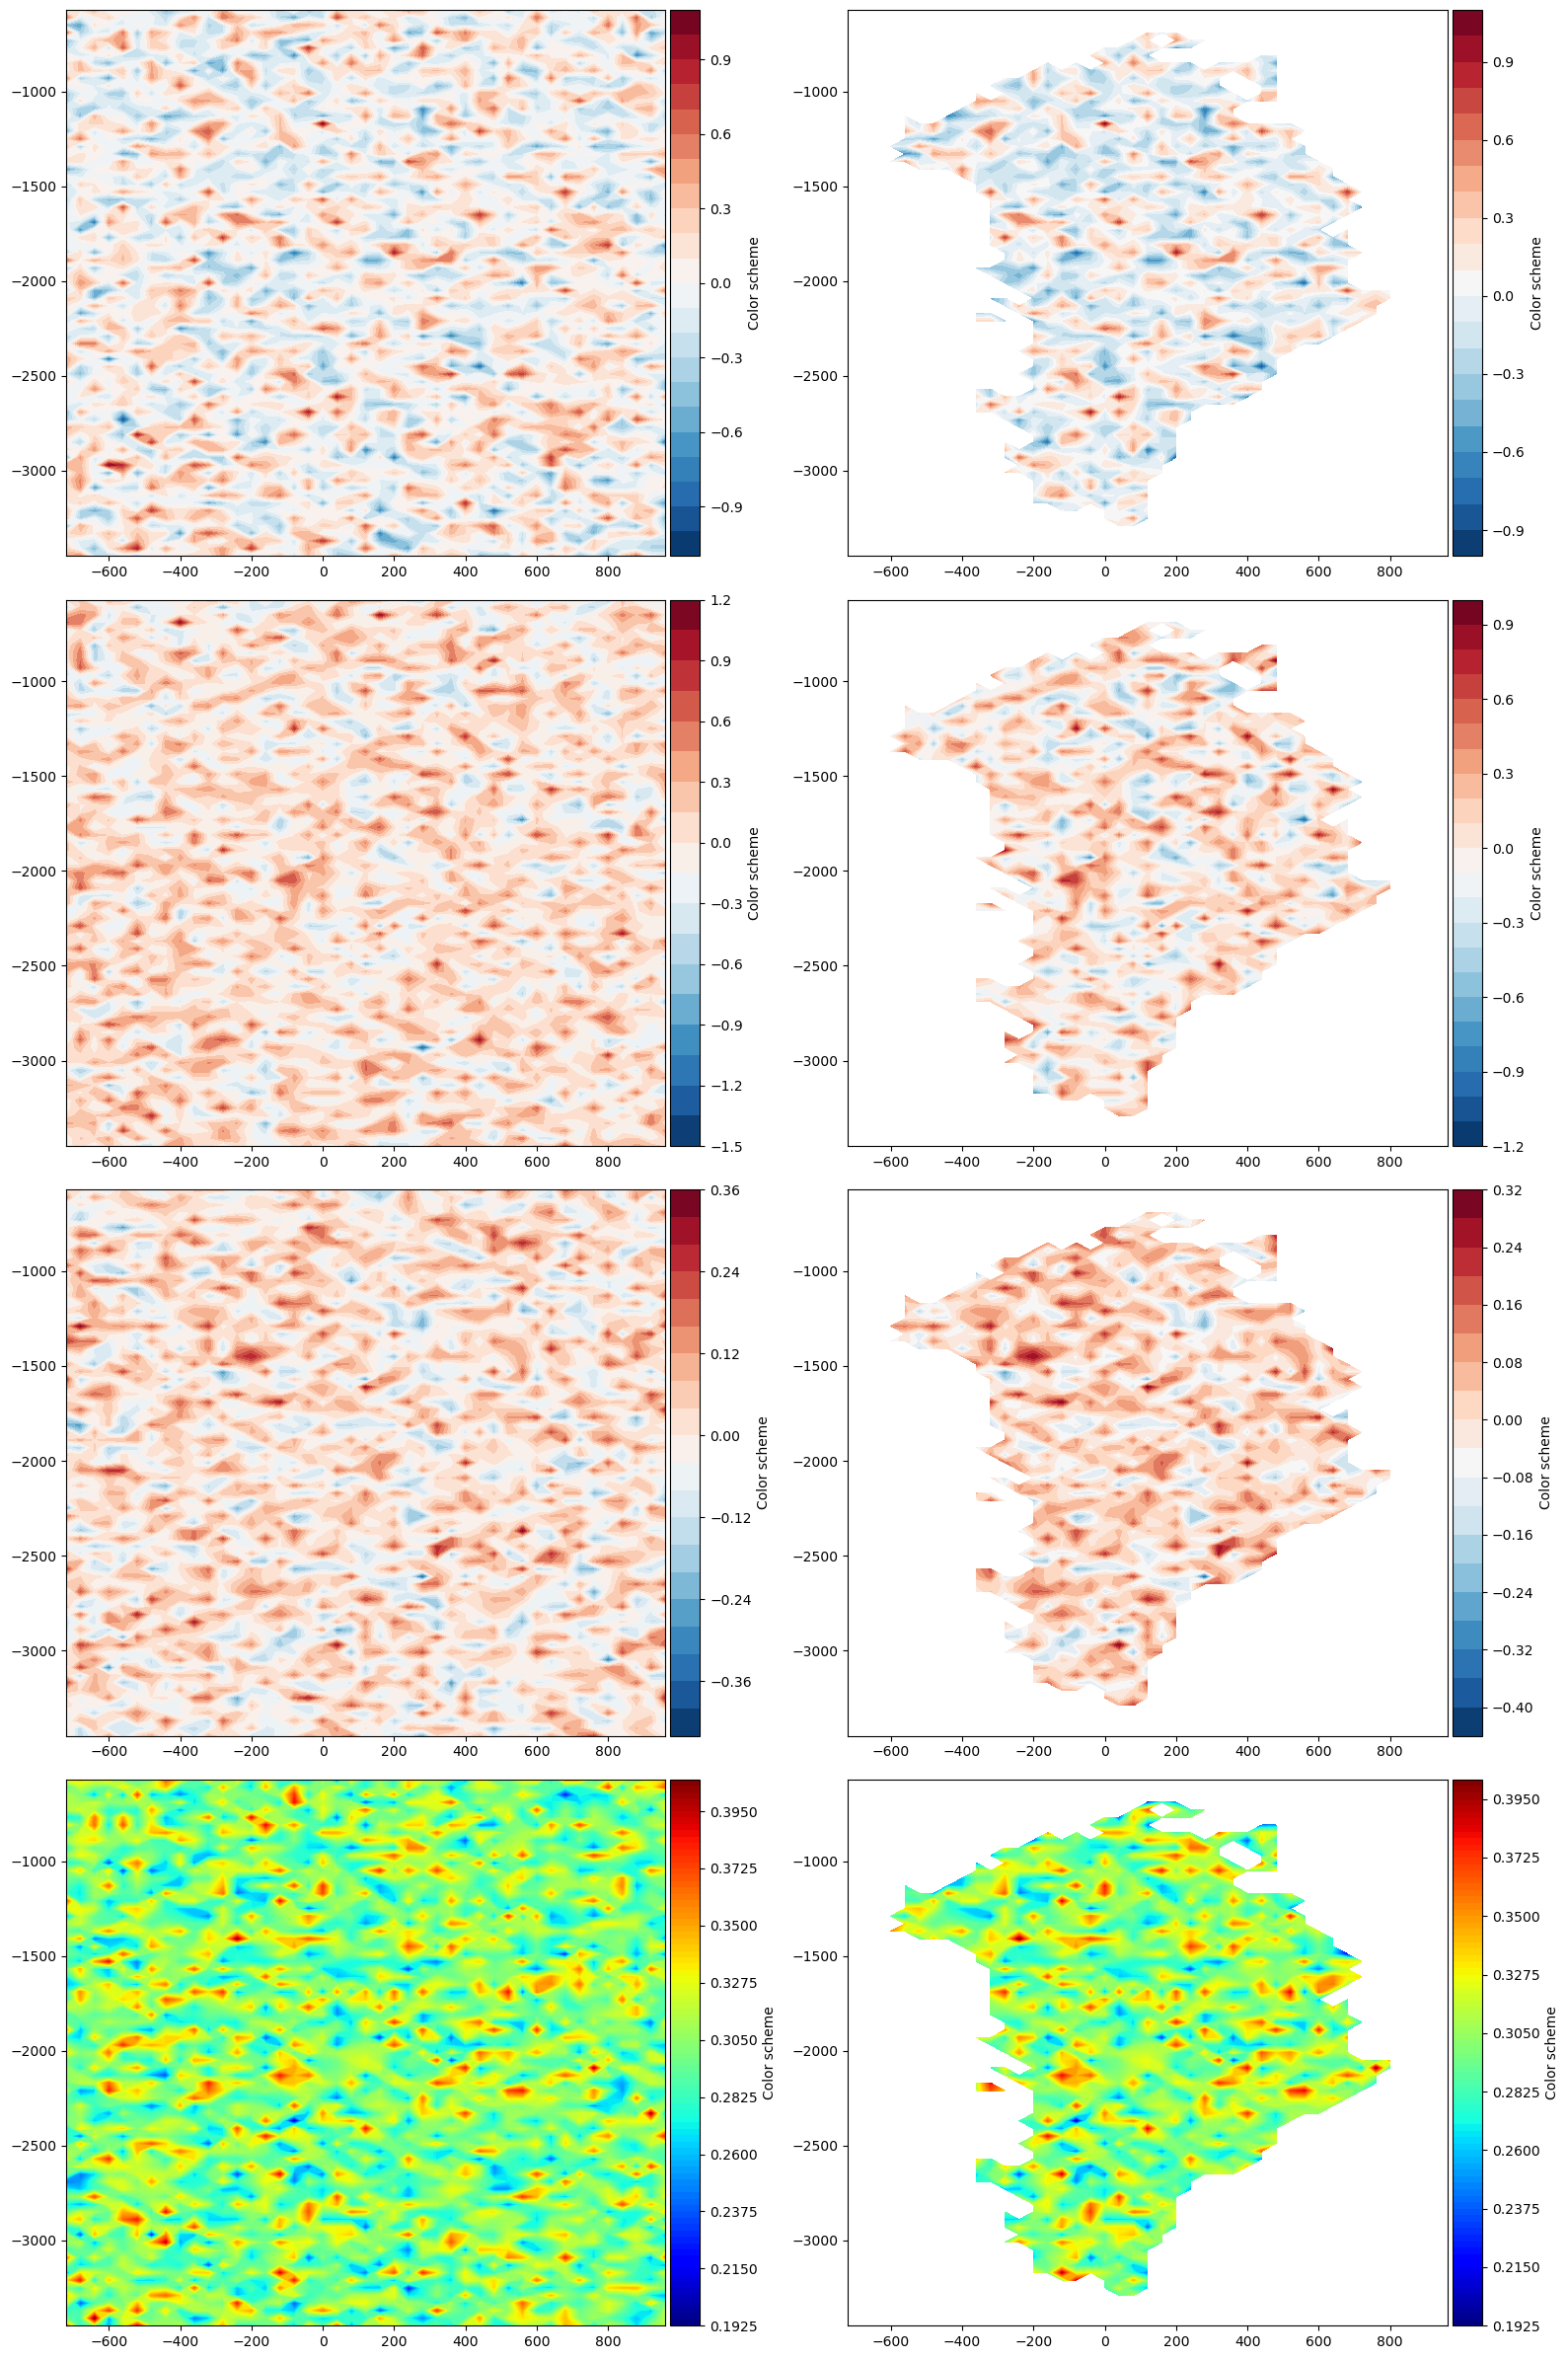

In [7]:
H_data_40 = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/bm5_data_40kms.nc")
H_data = H_data_40["H"].data
mask = 1.0*(H_data > 0)
mask[mask == 0] = np.nan

plt.rcParams["figure.figsize"] = (16,24)
fig, ax = plt.subplots(4, 2)
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_subset_sample_prior_1["xx_age_cd"].data[40],
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[0, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_subset_sample_prior_1["xx_age_cd"].data[40]*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[0, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_subset_sample_prior_2["xx_age_cd"].data[40],
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[1, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_subset_sample_prior_2["xx_age_cd"].data[40]*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[1, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_mean_samples_prior["xx_age_cd"].data[40]/ds_std_samples_prior["xx_age_cd"].data[40],
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[2, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_mean_samples_prior["xx_age_cd"].data[40]/ds_std_samples_prior["xx_age_cd"].data[40]*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[2, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_std_samples_prior["xx_age_cd"].data[40],
                         cmap = 'jet', nbins = 100, fig = fig, ax = ax[3, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_std_samples_prior["xx_age_cd"].data[40]*mask,
                         cmap = 'jet', nbins = 100, fig = fig, ax = ax[3, 1])
plt.tight_layout()

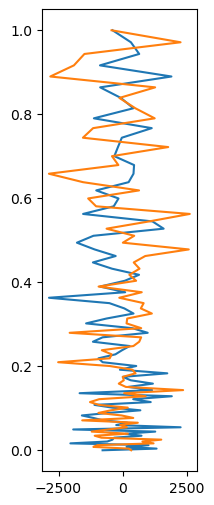

In [8]:
plt.rcParams["figure.figsize"] = (2, 6)
plt.plot(ds_subset_sample_prior_C_1["xx_age_cd"].data[:, 35, 20], exp_sigma_level)
plt.plot(ds_subset_sample_prior_C_2["xx_age_cd"].data[:, 35, 20], exp_sigma_level)
# plt.gca().invert_yaxis()  # Optional: Invert y-axis if needed

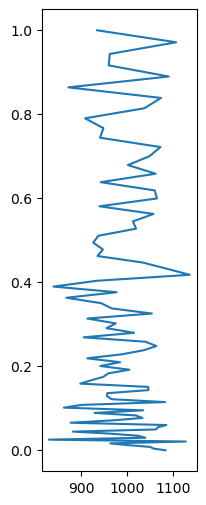

In [9]:
plt.rcParams["figure.figsize"] = (2, 6)
plt.plot(ds_std_samples_prior_C["xx_age_cd"].data[:, 35, 20], exp_sigma_level)
# plt.gca().invert_yaxis()  # Optional: Invert y-axis if needed

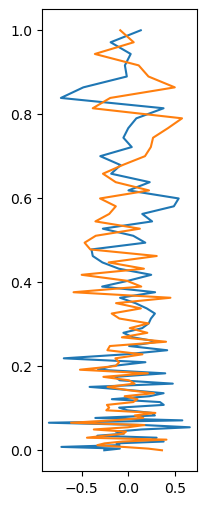

In [10]:
plt.rcParams["figure.figsize"] = (2, 6)
plt.plot(ds_subset_sample_prior_1["xx_age_cd"].data[:, 35, 20], exp_sigma_level)
plt.plot(ds_subset_sample_prior_2["xx_age_cd"].data[:, 35, 20], exp_sigma_level)
# plt.gca().invert_yaxis()  # Optional: Invert y-axis if needed

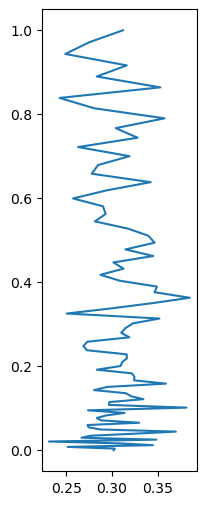

In [11]:
plt.rcParams["figure.figsize"] = (2, 6)
plt.plot(ds_std_samples_prior["xx_age_cd"].data[:, 35, 20], exp_sigma_level)
# plt.gca().invert_yaxis()  # Optional: Invert y-axis if needed

In [12]:
ds_x = DA.create_ad_tlm_action_input_nc(bool_randomize = True)
ds_Ax = DA.eval_tlm_action()
ds_noise_cov_inv_Ax = DA.eval_noise_cov_inv_action(ds_Ax)
ds_H_misfit_x = DA.eval_misfit_hessian_action()

DA.l2_inner_product([ds_x, ds_H_misfit_x], ["tlm", "adj"]), DA.l2_inner_product([ds_Ax, ds_noise_cov_inv_Ax], ["tlmhessaction", "adjhessaction"])

(323317235.76199806, 323317235.761998)

In [13]:
dict_tlm_action_only_fields_vals = {}
for var in ds_x:
    if DA.dict_tlm_action_fields_or_scalars[var] == "scalar":
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data[0].copy()
    else:
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data.copy()
ds_x = DA.create_ad_tlm_action_input_nc(dict_tlm_action_only_fields_vals)
    
ds_Ax = DA.eval_tlm_action()
ds_noise_cov_inv_Ax = DA.eval_noise_cov_inv_action(ds_Ax)
ds_H_misfit_x = DA.eval_misfit_hessian_action()

DA.l2_inner_product([ds_x, ds_H_misfit_x], ["tlm", "adj"]), DA.l2_inner_product([ds_Ax, ds_noise_cov_inv_Ax], ["tlmhessaction", "adjhessaction"])

(323317235.76199806, 323317235.761998)

In [14]:
dict_tlm_action_only_fields_vals = {}
for var in ds_x:
    if DA.dict_tlm_action_fields_or_scalars[var] == "scalar":
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data[0].copy()
    else:
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data.copy()
ds_x = DA.create_ad_tlm_action_input_nc(dict_tlm_action_only_fields_vals)
    
ds_Ax = DA.eval_tlm_action()
ds_noise_cov_inv_Ax = DA.eval_noise_cov_inv_action(ds_Ax)
ds_H_misfit_x = DA.eval_misfit_hessian_action()

ds_SigmaXCx = DA.eval_sqrt_prior_cov_action(ad_key_adj_or_tlm_action = "tlm_action")
ds_A_SigmaXCx = DA.eval_tlm_action()
ds_noise_cov_inv_A_SigmaXCx = DA.eval_noise_cov_inv_action(ds_A_SigmaXCx)

dict_tlm_action_only_fields_vals = {}
for var in ds_x:
    if DA.dict_tlm_action_fields_or_scalars[var] == "scalar":
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data[0].copy()
    else:
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data.copy()
ds_x = DA.create_ad_tlm_action_input_nc(dict_tlm_action_only_fields_vals)

ds_CT_XT_SigmaT_H_misfit_SigmaXCx = DA.eval_prior_preconditioned_misfit_hessian_action()

DA.l2_inner_product([ds_x, ds_CT_XT_SigmaT_H_misfit_SigmaXCx], ["tlm", "adj"]), DA.l2_inner_product([ds_A_SigmaXCx, ds_noise_cov_inv_A_SigmaXCx], ["tlmhessaction", "adjhessaction"])

(30320262.573556293, 30320262.588405292)

In [15]:
dict_tlm_action_only_fields_vals = {}
for var in ds_x:
    if DA.dict_tlm_action_fields_or_scalars[var] == "scalar":
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data[0].copy()
    else:
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data.copy()
ds_x = DA.create_ad_tlm_action_input_nc(dict_tlm_action_only_fields_vals)
ds_SigmaXCx = DA.eval_sqrt_prior_cov_action(ad_key_adj_or_tlm_action = "tlm_action")
ds_SigmaXC_inv_SigmaXCx = DA.eval_sqrt_prior_cov_inv_action()

DA.l2_inner_product([ds_SigmaXC_inv_SigmaXCx, ds_SigmaXC_inv_SigmaXCx], ["tlm", "tlm"]), DA.l2_inner_product([ds_x, ds_x], ["tlm", "tlm"])

(544423.4936990144, 544423.4936990144)

In [16]:
DA.l2_inner_product([ds_SigmaXCx, ds_SigmaXCx], ["tlm", "tlm"]), DA.l2_inner_product([ds_x, ds_x], ["tlm", "tlm"])

(873314591.5122074, 544423.4936990144)

In [17]:
dict_tlm_action_only_fields_vals = {}
for var in ds_x:
    if DA.dict_tlm_action_fields_or_scalars[var] == "scalar":
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data[0].copy()
    else:
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data.copy()

ds_x = DA.create_ad_tlm_action_input_nc(dict_tlm_action_only_fields_vals)
ds_SigmaXCx = DA.eval_sqrt_prior_cov_action(ad_key_adj_or_tlm_action = "tlm_action")

ds_SigmaXCx_as_adj_fields = xr.open_dataset(DA.dict_ad_inp_nc_files["tlm_action"])
ds_SigmaXCx_as_adj_fields = ds_SigmaXCx_as_adj_fields.rename({field + "d": field + "b" for field in dict_og_params_fields_vals})
for var in ds_SigmaXCx_as_adj_fields:
    if ds_SigmaXCx_as_adj_fields[var].attrs["type"] == "tlm":
        ds_SigmaXCx_as_adj_fields[var].attrs["type"] = "adj"
        if dict_params_fields_or_scalars[var[:-1]] == "scalar" and dict_params_fields_num_dims[var[:-1]] == "2D":
            ds_SigmaXCx_as_adj_fields[var].data[:, :] = ds_SigmaXCx_as_adj_fields[var].data.flat[0]/((IMAX+1)*(JMAX+1))
        elif dict_params_fields_or_scalars[var[:-1]] == "scalar" and dict_params_fields_num_dims[var[:-1]] == "3D":
            ds_SigmaXCx_as_adj_fields[var].data[:, :] = ds_SigmaXCx_as_adj_fields[var].data.flat[0]/((IMAX+1)*(JMAX+1)*(KCMAX+1))
ds_SigmaXCx_as_adj_fields.to_netcdf(DA.dict_ad_out_nc_files["adj_action"])

ds_CT_XT_SigmaT_SigmaXCx = DA.eval_sqrt_prior_covT_action(ad_key_adj_or_adj_action = "adj_action")

DA.l2_inner_product([ds_SigmaXCx, ds_SigmaXCx], ["tlm", "tlm"]), DA.l2_inner_product([ds_x, ds_CT_XT_SigmaT_SigmaXCx], ["tlm", "adj"])

(873314591.5122074, 873314591.5122269)

In [18]:
dict_tlm_action_only_fields_vals = {}
for var in ds_x:
    if DA.dict_tlm_action_fields_or_scalars[var] == "scalar":
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data[0].copy()
    else:
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data.copy()
ds_x = DA.create_ad_tlm_action_input_nc(dict_tlm_action_only_fields_vals)
ds_CT_XT_SigmaT_H_SigmaXCx = DA.eval_prior_preconditioned_hessian_action()

DA.l2_inner_product([ds_x, ds_CT_XT_SigmaT_H_misfit_SigmaXCx], ["tlm", "adj"]), \
DA.l2_inner_product([ds_x, ds_CT_XT_SigmaT_H_misfit_SigmaXCx], ["tlm", "adj"]) + DA.l2_inner_product([ds_x, ds_x], ["tlm", "tlm"]), \
DA.l2_inner_product([ds_x, ds_CT_XT_SigmaT_H_SigmaXCx], ["tlm", "adj"])

(30320262.573556293, 30864686.067255307, 30864686.067255307)

In [19]:
DA = optim.DataAssimilation(sicopolis_dir, simulation,
                            dict_sico_out_folder_prefixes, dict_ad_exec_cmds_suffixes,
                            dict_ad_log_file_suffixes, dict_ad_nc_suffixes,
                            dict_og_params_fields_vals, dict_params_fields_num_dims, 
                            dict_params_coords, dict_params_attrs_type, dict_params_fields_or_scalars, dict_masks_observables,
                            dict_prior_sigmas, dict_prior_gammas, dict_prior_deltas,
                            MAX_ITERS_SOR, OMEGA_SOR, list_fields_to_ignore, False, None, "/scratch2/shreyas/tuneAll_mini", None, ds_prior_X)

DA.gradient_descent(1)

---------------------------------------------------------------------------------------------------------------
iter 0, fc = 12504290.731311508, fc_data = 12504290.731311508, fc_reg = 6.793294453121298e-40
---------------------------------------------------------------------------------------------------------------
Too big step size probably crashed the simulation.
Too big step size probably crashed the simulation.
Too big step size probably crashed the simulation.
Too big step size probably crashed the simulation.
Too big step size probably crashed the simulation.
Too big step size probably crashed the simulation.
Too big step size probably crashed the simulation.
Too big step size probably crashed the simulation.
Too big step size probably crashed the simulation.
Too big step size probably crashed the simulation.
Too big step size probably crashed the simulation.
Too big step size probably crashed the simulation.
Step size alpha = 7.62939453125e-06
----------------------------------

<xarray.Dataset> Size: 4MB
Dimensions:                        (y: 73, x: 43, scalar: 1, zeta_c: 81,
                                    time_ad: 3)
Coordinates:
  * y                              (y) float64 584B -3.45e+03 ... -570.0
  * x                              (x) float64 344B -720.0 -680.0 ... 960.0
  * zeta_c                         (zeta_c) float64 648B 0.0 0.003962 ... 1.0
  * time_ad                        (time_ad) float64 24B 0.0 1.0 2.0
Dimensions without coordinates: scalar
Data variables: (12/24)
    xx_c_slide_init                (y, x) float64 25kB 0.9294 0.9294 ... 0.9294
    xx_c_dis_da                    (scalar) float64 8B 4.219
    xx_q_geo                       (y, x) float64 25kB -1.286 -1.28 ... -1.146
    xx_H                           (y, x) float64 25kB -5.0 -5.0 ... -5.0 -5.0
    xx_gamma_s                     (y, x) float64 25kB -1.152 -1.152 ... -1.152
    xx_s_stat                      (scalar) float64 8B 0.7036
    ...                             ...
    xx_zl                          (y, x) float64 25kB 0.0 0.0 0.0 ... 0.0 0.0
    xx_zl0                         (y, x) float64 25kB 0.0 0.0 0.0 ... 0.0 0.0
    xx_zb                          (y, x) float64 25kB 0.0 0.0 0.0 ... 0.0 0.0
    xx_temp_c                      (zeta_c, y, x) float64 2MB 0.0 0.0 ... 0.0
    xx_age_c                       (zeta_c, y, x) float64 2MB -5.0 -5.0 ... -5.0
    xx_delta_tda                   (time_ad, y, x) float64 75kB 0.0 0.0 ... 0.0

In [20]:
DA = optim.DataAssimilation(sicopolis_dir, simulation,
                            dict_sico_out_folder_prefixes, dict_ad_exec_cmds_suffixes,
                            dict_ad_log_file_suffixes, dict_ad_nc_suffixes,
                            dict_og_params_fields_vals, dict_params_fields_num_dims, 
                            dict_params_coords, dict_params_attrs_type, dict_params_fields_or_scalars, dict_masks_observables,
                            dict_prior_sigmas, dict_prior_gammas, dict_prior_deltas,
                            MAX_ITERS_SOR, OMEGA_SOR, list_fields_to_ignore, False, None, "/scratch2/shreyas/tuneAll_mini", None, ds_prior_X)

DA.inexact_gn_hessian_cg(MAX_ITERS=2, init_alpha_gd = 1.e-6)

---------------------------------------------------------------------------------------------------------------
Initial fc = 12504290.731311508, fc_data = 12504290.731311508, fc_reg = 6.793294453121298e-40
---------------------------------------------------------------------------------------------------------------
CG iter 1
eps_TOL_CG: 153532.05925509197, norm_r_hat: 277461.9978585867
CG iter 2
eps_TOL_CG: 153532.05925509197, norm_r_hat: 188106.37864442397
H-orthoganality check = 2.4193506564367643e-08
CG iter 3
eps_TOL_CG: 153532.05925509197, norm_r_hat: 250585.76837904597
H-orthoganality check = 2.675090157012798e-08
CG iter 4
eps_TOL_CG: 153532.05925509197, norm_r_hat: 154282.11079410082
H-orthoganality check = 1.5078329438719488e-08
CG iter 5
eps_TOL_CG: 153532.05925509197, norm_r_hat: 161702.27598715445
H-orthoganality check = 1.4889238022313343e-08
CG iter 6
eps_TOL_CG: 153532.05925509197, norm_r_hat: 178776.39541264516
H-orthoganality check = 1.6661117265169266e-08
CG iter 7
e

<xarray.Dataset> Size: 4MB
Dimensions:                        (y: 73, x: 43, scalar: 1, zeta_c: 81,
                                    time_ad: 3)
Coordinates:
  * y                              (y) float64 584B -3.45e+03 ... -570.0
  * x                              (x) float64 344B -720.0 -680.0 ... 960.0
  * zeta_c                         (zeta_c) float64 648B 0.0 0.003962 ... 1.0
  * time_ad                        (time_ad) float64 24B 0.0 1.0 2.0
Dimensions without coordinates: scalar
Data variables: (12/24)
    xx_c_slide_init                (y, x) float64 25kB 0.9294 0.9294 ... 0.9294
    xx_c_dis_da                    (scalar) float64 8B 4.228
    xx_q_geo                       (y, x) float64 25kB -1.286 -1.28 ... -1.146
    xx_H                           (y, x) float64 25kB -5.0 -5.0 ... -5.0 -5.0
    xx_gamma_s                     (y, x) float64 25kB -1.152 -1.152 ... -1.152
    xx_s_stat                      (scalar) float64 8B 0.7114
    ...                             ...
    xx_zl                          (y, x) float64 25kB 1.254e-06 ... 8.404e-06
    xx_zl0                         (y, x) float64 25kB 2.661e-09 ... 1.284e-08
    xx_zb                          (y, x) float64 25kB 0.0 0.0 0.0 ... 0.0 0.0
    xx_temp_c                      (zeta_c, y, x) float64 2MB 0.0 0.0 ... 0.0
    xx_age_c                       (zeta_c, y, x) float64 2MB -5.0 -5.0 ... -5.0
    xx_delta_tda                   (time_ad, y, x) float64 75kB 1.055e-14 ......

Double precise total time: 17126.1077 seconds
Single approx total time: 8513.4151 seconds


(array([7.72710020e+08, 7.88848385e+07, 8.47461759e+05, 2.12828861e+05,
        1.18191181e+05, 8.26037813e+04, 3.76922615e+04, 3.43723943e+04,
        2.13692168e+04, 2.00525819e+04, 1.43753659e+04, 1.40867391e+04,
        1.12103180e+04, 9.54478609e+03, 8.87909564e+03, 7.25199747e+03,
        6.58905138e+03, 6.57899353e+03, 5.82625707e+03, 5.51963193e+03,
        4.86165101e+03, 4.82004091e+03, 4.50660180e+03, 4.19156991e+03,
        3.92347405e+03, 3.82431146e+03, 3.69297653e+03, 3.50742278e+03,
        3.37245361e+03, 3.24184207e+03, 3.07287229e+03, 2.96159738e+03,
        2.88334660e+03, 2.83254862e+03, 2.78501134e+03, 2.72800889e+03,
        2.59131750e+03, 2.39851869e+03, 2.37255160e+03, 2.23833754e+03]),
 array([7.72304333e+08, 7.82681255e+07, 5.31814742e+05, 6.57354465e+04,
        3.08610115e+04, 1.52965922e+04, 5.65281687e+03, 4.94179192e+03,
        3.76220290e+03, 3.12208979e+03, 2.82515578e+03, 2.69197553e+03,
        2.45323998e+03, 2.34796718e+03, 2.28580811e+03, 2.0074

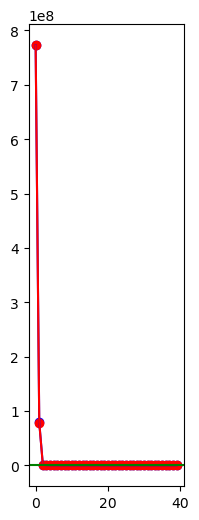

In [21]:
start_dp = time.time()

Omega_misfit_dp, Y_misfit_dp, Q_misfit_dp, MQ_misfit_dp, U_misfit_dp, Lambda_misfit_dp, S_misfit_dp = DA.revd(15, 5, mode = "misfit_prior_precond", str_pass = "double_precise")
Omega_misfit_dp, Y_misfit_dp, Q_misfit_dp, MQ_misfit_dp, U_misfit_dp, Lambda_misfit_dp, S_misfit_dp = DA.revd(15, 5, mode = "misfit_prior_precond", str_pass = "double_precise", 
                                                                                                              Omega = Omega_misfit_dp, Y = Y_misfit_dp, Q = Q_misfit_dp, MQ = MQ_misfit_dp)

end_dp = time.time()
print(f"Double precise total time: {end_dp - start_dp:.4f} seconds")
start_sa = time.time()

Omega_misfit_sa, Y_misfit_sa, Q_misfit_sa, MQ_misfit_sa, U_misfit_sa, Lambda_misfit_sa, S_misfit_sa = DA.revd(15, 5, mode = "misfit_prior_precond", str_pass = "single_approx")
Omega_misfit_sa, Y_misfit_sa, Q_misfit_sa, MQ_misfit_sa, U_misfit_sa, Lambda_misfit_sa, S_misfit_sa = DA.revd(15, 5, mode = "misfit_prior_precond", str_pass = "single_approx", 
                                                                                                              Omega = Omega_misfit_sa, Y = Y_misfit_sa, Q = Q_misfit_sa, MQ = MQ_misfit_sa)

end_sa = time.time()
print(f"Single approx total time: {end_sa - start_sa:.4f} seconds")

plt.scatter(np.arange(Lambda_misfit_dp.shape[0]), np.sort(Lambda_misfit_dp)[::-1], color = "blue")
plt.plot(np.sort(Lambda_misfit_dp)[::-1], color = "blue")
plt.scatter(np.arange(Lambda_misfit_sa.shape[0]), np.sort(Lambda_misfit_sa)[::-1], color = "red")
plt.plot(np.sort(Lambda_misfit_sa)[::-1], color = "red")

plt.axhline(1, color = "green")

np.sort(Lambda_misfit_dp)[::-1], np.sort(Lambda_misfit_sa)[::-1]

Double precise total time: 16948.9541 seconds
Single approx total time: 8518.1018 seconds


(array([7.72710020e+08, 7.88848456e+07, 8.47255967e+05, 2.09028284e+05,
        1.17560438e+05, 7.78818947e+04, 3.48279523e+04, 3.17180792e+04,
        2.31070825e+04, 1.86691640e+04, 1.76311626e+04, 1.41999875e+04,
        1.29610396e+04, 8.42050354e+03, 7.95383722e+03, 7.65291031e+03,
        6.63378084e+03, 5.75387862e+03, 5.52872617e+03, 5.01390598e+03,
        4.74380547e+03, 4.46303942e+03, 4.22213680e+03, 4.04402489e+03,
        3.86109088e+03, 3.72510342e+03, 3.50173315e+03, 3.38736179e+03,
        3.21327689e+03, 3.04727235e+03, 3.00345348e+03, 2.86004647e+03,
        2.84589086e+03, 2.68172167e+03, 2.54900129e+03, 2.51862657e+03,
        2.49034351e+03, 2.35528313e+03, 2.18982271e+03, 2.12982644e+03]),
 array([7.72246456e+08, 7.84827942e+07, 5.36142227e+05, 9.63796406e+04,
        1.83851701e+04, 1.52871486e+04, 7.87751070e+03, 4.18343897e+03,
        3.72275143e+03, 3.15129178e+03, 2.74935542e+03, 2.46947608e+03,
        2.42173428e+03, 2.22644438e+03, 2.10255677e+03, 2.0521

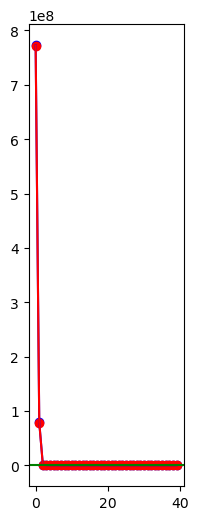

In [22]:
start_dp = time.time()

Omega_misfit_dp, Y_misfit_dp, Q_misfit_dp, MQ_misfit_dp, U_misfit_dp, Lambda_misfit_dp, S_misfit_dp = DA.revd(15, 5, mode = "misfit_prior_precond", str_pass = "double_precise")
Omega_misfit_dp = np.load("/scratch2/shreyas/tuneAll_mini/REVD_double_precise/Omega_misfit.npy")
Y_misfit_dp = np.load("/scratch2/shreyas/tuneAll_mini/REVD_double_precise/Y_misfit.npy")
Q_misfit_dp = np.load("/scratch2/shreyas/tuneAll_mini/REVD_double_precise/Q_misfit.npy")
MQ_misfit_dp = np.load("/scratch2/shreyas/tuneAll_mini/REVD_double_precise/MQ_misfit.npy")
Omega_misfit_dp, Y_misfit_dp, Q_misfit_dp, MQ_misfit_dp, U_misfit_dp, Lambda_misfit_dp, S_misfit_dp = DA.revd(15, 5, mode = "misfit_prior_precond", str_pass = "double_precise", 
                                                                                                              Omega = Omega_misfit_dp, Y = Y_misfit_dp, Q = Q_misfit_dp, MQ = MQ_misfit_dp)

end_dp = time.time()
print(f"Double precise total time: {end_dp - start_dp:.4f} seconds")
start_sa = time.time()

Omega_misfit_sa, Y_misfit_sa, Q_misfit_sa, MQ_misfit_sa, U_misfit_sa, Lambda_misfit_sa, S_misfit_sa = DA.revd(15, 5, mode = "misfit_prior_precond", str_pass = "single_approx")
Omega_misfit_sa = np.load("/scratch2/shreyas/tuneAll_mini/REVD_single_approx/Omega_misfit.npy")
Y_misfit_sa = np.load("/scratch2/shreyas/tuneAll_mini/REVD_single_approx/Y_misfit.npy")
Q_misfit_sa = np.load("/scratch2/shreyas/tuneAll_mini/REVD_single_approx/Q_misfit.npy")
MQ_misfit_sa = np.load("/scratch2/shreyas/tuneAll_mini/REVD_single_approx/MQ_misfit.npy")
Omega_misfit_sa, Y_misfit_sa, Q_misfit_sa, MQ_misfit_sa, U_misfit_sa, Lambda_misfit_sa, S_misfit_sa = DA.revd(15, 5, mode = "misfit_prior_precond", str_pass = "single_approx", 
                                                                                                              Omega = Omega_misfit_sa, Y = Y_misfit_sa, Q = Q_misfit_sa, MQ = MQ_misfit_sa)

end_sa = time.time()
print(f"Single approx total time: {end_sa - start_sa:.4f} seconds")

plt.scatter(np.arange(Lambda_misfit_dp.shape[0]), np.sort(Lambda_misfit_dp)[::-1], color = "blue")
plt.plot(np.sort(Lambda_misfit_dp)[::-1], color = "blue")
plt.scatter(np.arange(Lambda_misfit_sa.shape[0]), np.sort(Lambda_misfit_sa)[::-1], color = "red")
plt.plot(np.sort(Lambda_misfit_sa)[::-1], color = "red")

plt.axhline(1, color = "green")

np.sort(Lambda_misfit_dp)[::-1], np.sort(Lambda_misfit_sa)[::-1]

Double precise total time: 16870.5909 seconds
Single approx total time: 8566.2646 seconds


(array([7.72710019e+08, 7.88848527e+07, 8.47641683e+05, 2.10028521e+05,
        1.19876336e+05, 8.34482688e+04, 3.53831863e+04, 3.18081222e+04,
        2.37039601e+04, 1.78023800e+04, 1.47192767e+04, 1.35635078e+04,
        1.14708042e+04, 9.38501105e+03, 8.55160854e+03, 7.82789015e+03,
        7.09308130e+03, 6.70910977e+03, 5.89475313e+03, 5.34115099e+03,
        4.85679937e+03, 4.57299579e+03, 4.31283693e+03, 4.30595196e+03,
        4.01142272e+03, 3.78703959e+03, 3.76451757e+03, 3.58432761e+03,
        3.29668123e+03, 3.25233256e+03, 3.20353121e+03, 3.03643043e+03,
        2.91547524e+03, 2.82997022e+03, 2.76035309e+03, 2.65696904e+03,
        2.64121922e+03, 2.56862113e+03, 2.42577073e+03, 2.27662415e+03]),
 array([7.72289554e+08, 7.83071475e+07, 5.28679026e+05, 6.06355987e+04,
        2.51873918e+04, 1.48587913e+04, 6.54646888e+03, 4.97854176e+03,
        4.38894128e+03, 3.66496440e+03, 3.21719145e+03, 2.84191300e+03,
        2.47709405e+03, 2.21669305e+03, 2.09540806e+03, 2.0270

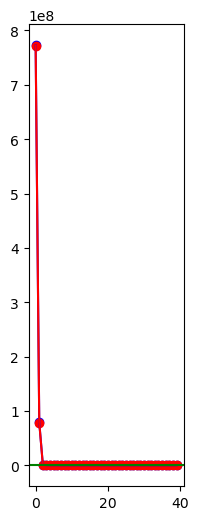

In [23]:
start_dp = time.time()
Omega_misfit_dp, Y_misfit_dp, Q_misfit_dp, MQ_misfit_dp, U_misfit_dp, Lambda_misfit_dp, S_misfit_dp = DA.revd(30, 10, mode = "misfit_prior_precond", str_pass = "double_precise")

end_dp = time.time()
print(f"Double precise total time: {end_dp - start_dp:.4f} seconds")
start_sa = time.time()

Omega_misfit_sa, Y_misfit_sa, Q_misfit_sa, MQ_misfit_sa, U_misfit_sa, Lambda_misfit_sa, S_misfit_sa = DA.revd(30, 10, mode = "misfit_prior_precond", str_pass = "single_approx")

end_sa = time.time()
print(f"Single approx total time: {end_sa - start_sa:.4f} seconds")

plt.scatter(np.arange(Lambda_misfit_dp.shape[0]), np.sort(Lambda_misfit_dp)[::-1], color = "blue")
plt.plot(np.sort(Lambda_misfit_dp)[::-1], color = "blue")
plt.scatter(np.arange(Lambda_misfit_sa.shape[0]), np.sort(Lambda_misfit_sa)[::-1], color = "red")
plt.plot(np.sort(Lambda_misfit_sa)[::-1], color = "red")

plt.axhline(1, color = "green")

np.sort(Lambda_misfit_dp)[::-1], np.sort(Lambda_misfit_sa)[::-1]

Double precise total time: 16875.9086 seconds
Single approx total time: 8413.5964 seconds


(array([7.72710020e+08, 7.88848514e+07, 8.47299395e+05, 2.12201210e+05,
        1.19574320e+05, 8.30473376e+04, 3.45744824e+04, 3.26323963e+04,
        2.55842730e+04, 1.95525676e+04, 1.54740011e+04, 1.38872948e+04,
        1.20058788e+04, 9.26131704e+03, 7.45291031e+03, 7.25318298e+03,
        6.47117351e+03, 6.12335638e+03, 5.77820868e+03, 5.11513985e+03,
        4.81245035e+03, 4.51013359e+03, 4.45569622e+03, 4.29209950e+03,
        4.19540909e+03, 3.77956565e+03, 3.70783120e+03, 3.50724856e+03,
        3.33923626e+03, 3.30077281e+03, 3.23141815e+03, 2.91489435e+03,
        2.80654054e+03, 2.71751996e+03, 2.68971249e+03, 2.59618900e+03,
        2.45820363e+03, 2.41359766e+03, 2.36034709e+03, 2.20400334e+03]),
 array([7.72437024e+08, 7.84718779e+07, 5.60025522e+05, 6.78281456e+04,
        3.33171868e+04, 1.21828038e+04, 6.35570149e+03, 4.72013901e+03,
        3.92740286e+03, 3.42772912e+03, 3.18073876e+03, 2.89876396e+03,
        2.34887923e+03, 2.23466998e+03, 2.08011154e+03, 2.0126

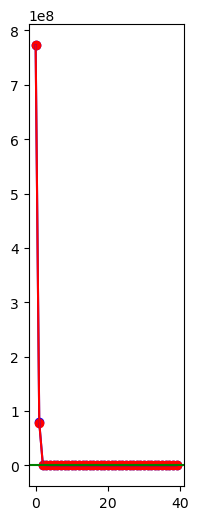

In [24]:
ds_state = xr.open_dataset("/scratch2/shreyas/tuneAll_mini/inexact_gn_hessian_cg/state_GNHessCG_iter_2.nc")
ds_prior_X = xr.open_dataset("/scratch2/shreyas/tuneAll_mini/prior_X.nc")

dict_og_params_fields_vals = {"xx_c_slide_init": ds_state["xx_c_slide_init"].data.copy(),
                              "xx_c_dis_da": ds_state["xx_c_dis_da"].data[0].copy(),
                              "xx_q_geo": ds_state["xx_q_geo"].data.copy(),
                              "xx_H": ds_state["xx_H"].data.copy(),
                              "xx_gamma_s": ds_state["xx_gamma_s"].data.copy(),
                              "xx_s_stat": ds_state["xx_s_stat"].data[0].copy(),
                              "xx_beta1": ds_state["xx_beta1"].data[0].copy(),
                              "xx_beta2": ds_state["xx_beta2"].data[0].copy(),
                              "xx_Pmax": ds_state["xx_Pmax"].data[0].copy(),
                              "xx_mu": ds_state["xx_mu"].data[0].copy(),
                              "xx_RHO_A": ds_state["xx_RHO_A"].data[0].copy(),
                              "xx_time_lag_asth": ds_state["xx_time_lag_asth"].data[0].copy(),
                              "xx_flex_rig_lith": ds_state["xx_flex_rig_lith"].data.copy(),
                              "xx_p_weert": ds_state["xx_p_weert"].data[0].copy(),
                              "xx_q_weert": ds_state["xx_q_weert"].data[0].copy(),
                              "xx_enh_fact_da_dummy2d_scalar": ds_state["xx_enh_fact_da_dummy2d_scalar"].data[0].copy(),
                              "xx_enh_intg_da_dummy2d_scalar": ds_state["xx_enh_intg_da_dummy2d_scalar"].data[0].copy(),
                              "xx_zs": ds_state["xx_zs"].data.copy(),
                              "xx_zl": ds_state["xx_zl"].data.copy(),
                              "xx_zl0": ds_state["xx_zl0"].data.copy(),
                              "xx_zb": ds_state["xx_zb"].data.copy(),
                              "xx_temp_c": ds_state["xx_temp_c"].data.copy(),
                              "xx_age_c": ds_state["xx_age_c"].data.copy(),
                              "xx_delta_tda": ds_state["xx_delta_tda"].data.copy()}

DA = optim.DataAssimilation(sicopolis_dir, simulation,
                            dict_sico_out_folder_prefixes, dict_ad_exec_cmds_suffixes,
                            dict_ad_log_file_suffixes, dict_ad_nc_suffixes,
                            dict_og_params_fields_vals, dict_params_fields_num_dims, 
                            dict_params_coords, dict_params_attrs_type, dict_params_fields_or_scalars, dict_masks_observables,
                            dict_prior_sigmas, dict_prior_gammas, dict_prior_deltas,
                            MAX_ITERS_SOR, OMEGA_SOR, list_fields_to_ignore, False, None, "/scratch2/shreyas/tuneAll_mini", None, ds_prior_X)

start_dp = time.time()

Omega_misfit_dp, Y_misfit_dp, Q_misfit_dp, MQ_misfit_dp, U_misfit_dp, Lambda_misfit_dp, S_misfit_dp = DA.revd(15, 5, mode = "misfit_prior_precond", str_pass = "double_precise")
Omega_misfit_dp = np.load("/scratch2/shreyas/tuneAll_mini/REVD_double_precise/Omega_misfit.npy")
Y_misfit_dp = np.load("/scratch2/shreyas/tuneAll_mini/REVD_double_precise/Y_misfit.npy")
Q_misfit_dp = np.load("/scratch2/shreyas/tuneAll_mini/REVD_double_precise/Q_misfit.npy")
MQ_misfit_dp = np.load("/scratch2/shreyas/tuneAll_mini/REVD_double_precise/MQ_misfit.npy")
Omega_misfit_dp, Y_misfit_dp, Q_misfit_dp, MQ_misfit_dp, U_misfit_dp, Lambda_misfit_dp, S_misfit_dp = DA.revd(15, 5, mode = "misfit_prior_precond", str_pass = "double_precise", 
                                                                                                              Omega = Omega_misfit_dp, Y = Y_misfit_dp, Q = Q_misfit_dp, MQ = MQ_misfit_dp)

end_dp = time.time()
print(f"Double precise total time: {end_dp - start_dp:.4f} seconds")
start_sa = time.time()

Omega_misfit_sa, Y_misfit_sa, Q_misfit_sa, MQ_misfit_sa, U_misfit_sa, Lambda_misfit_sa, S_misfit_sa = DA.revd(15, 5, mode = "misfit_prior_precond", str_pass = "single_approx")
Omega_misfit_sa = np.load("/scratch2/shreyas/tuneAll_mini/REVD_single_approx/Omega_misfit.npy")
Y_misfit_sa = np.load("/scratch2/shreyas/tuneAll_mini/REVD_single_approx/Y_misfit.npy")
Q_misfit_sa = np.load("/scratch2/shreyas/tuneAll_mini/REVD_single_approx/Q_misfit.npy")
MQ_misfit_sa = np.load("/scratch2/shreyas/tuneAll_mini/REVD_single_approx/MQ_misfit.npy")
Omega_misfit_sa, Y_misfit_sa, Q_misfit_sa, MQ_misfit_sa, U_misfit_sa, Lambda_misfit_sa, S_misfit_sa = DA.revd(15, 5, mode = "misfit_prior_precond", str_pass = "single_approx", 
                                                                                                              Omega = Omega_misfit_sa, Y = Y_misfit_sa, Q = Q_misfit_sa, MQ = MQ_misfit_sa)

end_sa = time.time()
print(f"Single approx total time: {end_sa - start_sa:.4f} seconds")

plt.scatter(np.arange(Lambda_misfit_dp.shape[0]), np.sort(Lambda_misfit_dp)[::-1], color = "blue")
plt.plot(np.sort(Lambda_misfit_dp)[::-1], color = "blue")
plt.scatter(np.arange(Lambda_misfit_sa.shape[0]), np.sort(Lambda_misfit_sa)[::-1], color = "red")
plt.plot(np.sort(Lambda_misfit_sa)[::-1], color = "red")

plt.axhline(1, color = "green")

np.sort(Lambda_misfit_dp)[::-1], np.sort(Lambda_misfit_sa)[::-1]

In [25]:
sigma_B_squared_dp, sigma_P_squared_dp, delta_sigma_qoi_squared_dp = DA.forward_uq_propagation(U_misfit_dp, Lambda_misfit_dp)
sigma_B_squared_sa, sigma_P_squared_sa, delta_sigma_qoi_squared_sa = DA.forward_uq_propagation(U_misfit_sa, Lambda_misfit_sa)

sigma_B_squared_dp, sigma_P_squared_dp, delta_sigma_qoi_squared_dp, sigma_B_squared_sa, sigma_P_squared_sa, delta_sigma_qoi_squared_sa

(3.6733211433797176e+28,
 3.200218969920837e+28,
 0.12879412253718525,
 3.6733211433797176e+28,
 3.3062225959980866e+28,
 0.09993641531812114)

In [26]:
# DA = optim.DataAssimilation(sicopolis_dir, simulation,
#                             dict_sico_out_folder_prefixes, dict_ad_exec_cmds_suffixes,
#                             dict_ad_log_file_suffixes, dict_ad_nc_suffixes,
#                             dict_og_params_fields_vals, dict_params_fields_num_dims, 
#                             dict_params_coords, dict_params_attrs_type, dict_params_fields_or_scalars, dict_masks_observables, 
#                             dict_prior_sigmas, dict_prior_gammas, dict_prior_deltas, 
#                             MAX_ITERS_SOR, OMEGA_SOR, None, True, "0002.nc", "/scratch2/shreyas/temp_dir", None, ds_prior_X)

# DA.l_bfgs(5, 3)